# Datasets

Download from [here](https://physionet.org/content/challenge-2021/1.0.3/#files-panel).  
To download only the required data use [download.py](../src/preprocessing/download.py) or  
`wget -r -N -c -np -A '*' -R 'index.html*' --cut-dirs=3 -nH https://physionet.org/files/challenge-2021/1.0.3/training/`

In [1]:
from collections import defaultdict
from pathlib import Path

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.io import loadmat
from tqdm import tqdm
import seaborn as sns

from scaling.datasets import PhysioNet, PhysionetDM
from scaling.augmentations import BasicECGAugmentation

ROOT = Path("/sc-scratch/sc-scratch-gbm-radiomics/ecg/physionet_challenge/training_pt")
dataset = PhysioNet(ROOT / "metadata_v4.csv")

## ECG data & Augmentation

In [3]:
transform = BasicECGAugmentation(
    crop_size=3000,
    max_warp=0.2, # Warps time by this percentage
    min_scale=0.5, # Amplitude scaling
    max_scale=2.0, # Amplitude scaling
    noise_std=0.01, # Gaussian noise std
    max_amplitude=1.0, # Amplitude of random wandering
    frequency_range=(0.5, 2.0), # Frequence range of random wandering
    max_mask_duration=50, # Max duration of zero masking
    mask_prob=0.33 # Probability to completely mask a lead (channel)
)

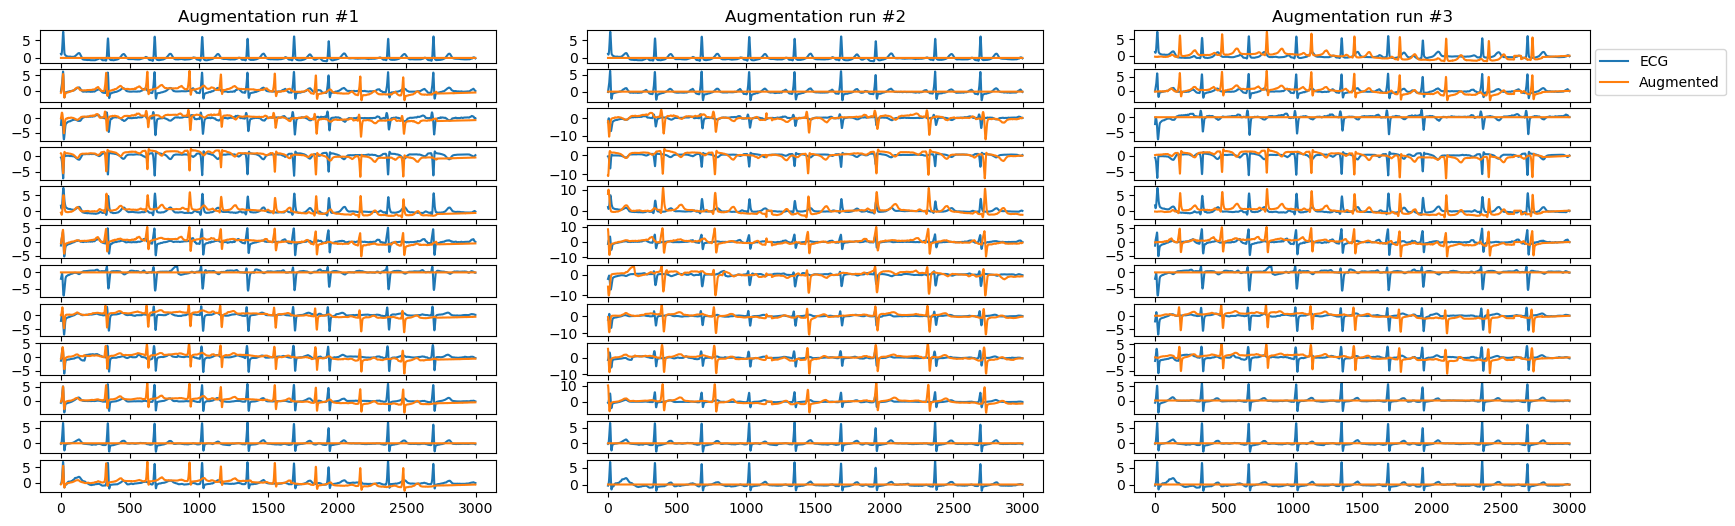

In [4]:
def plt_ecg(*ecgs, labels=None, w=None, h=None, axs=None):
    leads, length = ecgs[0].shape

    w = 6 if w is None else w
    h = leads // 2 if h is None else h

    fig = None
    if axs is None:
        fig, axs = plt.subplots(leads, 1, sharex=True)
        fig.set_size_inches(w=w, h=h)
    else:
        assert len(axs) == 12, "Need 12 rows in axs for all leads."

    for idx, ecg in enumerate(ecgs):
        for i, ax in enumerate(axs):
            label = labels[idx] if labels and idx < len(labels) else None
            ax.plot(ecg[i], label=label)
    
    return fig, axs
    
ecg, _ = dataset[1]

fig, axs = plt.subplots(12, 3, sharex=True)
fig.set_size_inches(w=20, h=6)
for i in range(3):
    axs[0, i].set_title(f"Augmentation run #{i + 1}")
    plt_ecg(
        ecg[:, :3000], 
        transform(ecg), 
        labels=["ECG", "Augmented"], 
        axs=axs[:, i]
    )
# Add legend to each subplot
axs[0, -1].legend(loc=[1.01, -1])
plt.show()


In [5]:
print(ecg.dtype)

torch.float32


## Multi-label stratifiction

We generated 4 folds in total. Fold 0-2 are used for a 3-fold CV and contain 30% of the data each. Fold 3 consists of the remaining 10% of the data and is only for testing.

In [2]:
N_FOLDS = 4

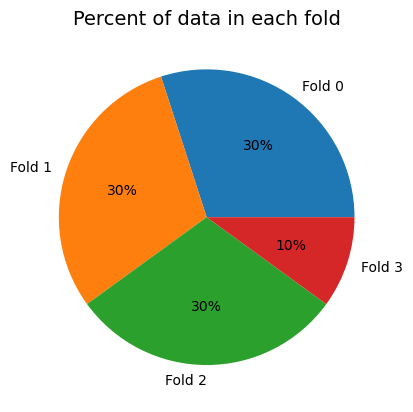

In [6]:
plt.title("Percent of data in each fold", fontsize=14)
plt.pie(dataset.meta.Fold.value_counts(), labels=[f"Fold {i}" for i in range(N_FOLDS)], autopct='%1.0f%%')
plt.show()

In [7]:
# Extract all labels
with tqdm(dataset.meta.iterrows(), total=len(dataset.meta), desc="Generate y tensor") as spbar:
    y = torch.stack([dataset.get_label(sample) for _, sample in spbar])

Generate y tensor: 100%|██████████| 88244/88244 [00:22<00:00, 3840.28it/s]


In [8]:
train_ratios = []
test_ratios = []

# Calculate ratios for each fold
for fold in range(N_FOLDS):   
    test = np.where(dataset.meta.Fold == fold)[0]
    train = np.where(dataset.meta.Fold != fold)[0]

    y_train, y_test = y[train], y[test]
    
    y_test_ratio = 100 * y_test.sum(axis=0) / y_test.sum()
    y_train_ratio = 100 * y_train.sum(axis=0) / y_train.sum()

    train_ratios.append(y_train_ratio.tolist())
    test_ratios.append(y_test_ratio.tolist())

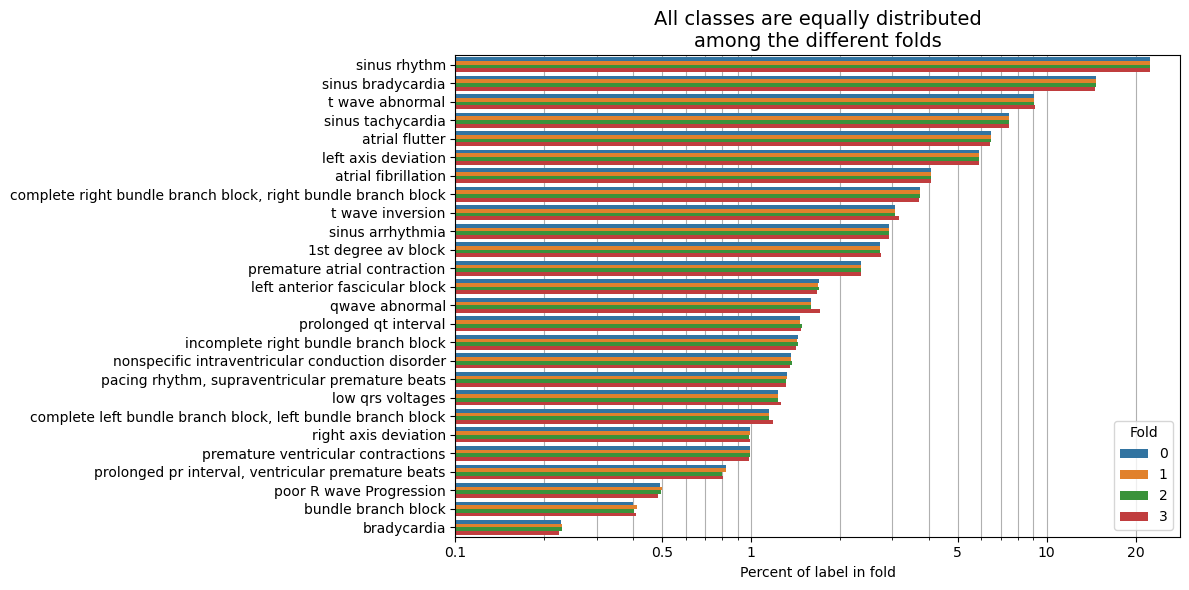

In [9]:
# Prepare data for plotting
fold_labels = list(range(N_FOLDS))
class_labels = [dataset.index_to_label(i, "Dx") for i in range(y.shape[1])]

train_data = pd.DataFrame(train_ratios, columns=class_labels, index=fold_labels).reset_index()
train_data['split'] = 'Train'

test_data = pd.DataFrame(test_ratios, columns=class_labels, index=fold_labels).reset_index()
test_data['split'] = 'Test'

plot_data = pd.concat([train_data, test_data])
plot_data = plot_data.melt(id_vars=['index', 'split'], var_name='class', value_name='percentage')

ticks = [0.1, 0.5, 1, 5, 10, 20]
tick_labels = [f"{t:.1f}" if t < 1 else f"{int(t)}" for t in ticks]

# Calculate total percentages for sorting
total_percentages = plot_data.groupby('class')['percentage'].sum()
sorted_classes = total_percentages.sort_values(ascending=False).index

# Update the 'class' column to a Categorical type with the sorted order
plot_data['class'] = pd.Categorical(plot_data['class'], categories=sorted_classes, ordered=True)

# Plot sorted by the most common label
plt.figure(figsize=(12, 6))
plt.title("All classes are equally distributed\namong the different folds", fontsize=14)
sns.barplot(
    data=plot_data[plot_data.split == "Test"], 
    y="class", 
    x="percentage", 
    hue="index",
    zorder=2,
    palette="tab10"
)
plt.xscale("log")
plt.xticks(ticks=ticks, labels=tick_labels)
plt.xlabel("Percent of label in fold")
plt.ylabel("")
plt.grid(axis="x", which="both")
plt.legend(title="Fold")
plt.tight_layout()
plt.show()


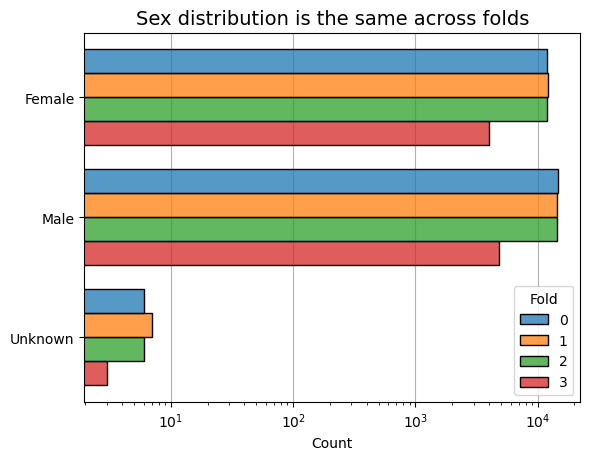

In [10]:
sns.histplot(data=dataset.meta, y="sex", hue="Fold", palette="tab10", multiple="dodge", shrink=0.8, zorder=2)
plt.ylabel("")
plt.grid(axis="x")
plt.title("Sex distribution is the same across folds", fontsize=14)
plt.xscale("log")
plt.show()

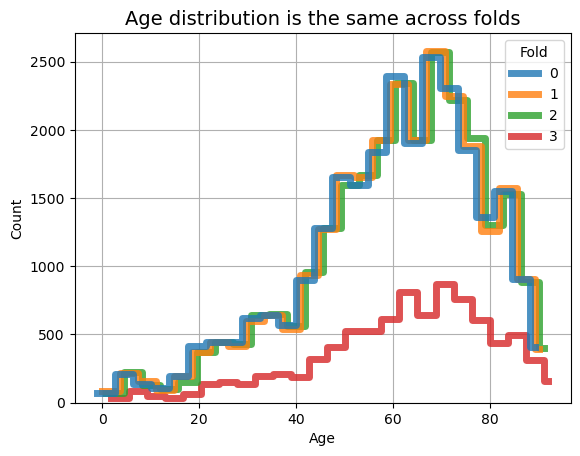

In [11]:
# Some patients have age annotated as 300. We set them to NaN
dataset.meta.loc[dataset.meta.age == 300, "age"] = np.nan
sns.histplot(data=dataset.meta, x="age", hue="Fold", bins=25, multiple="dodge", element="step", fill=False, palette="tab10", lw=5, alpha=0.8, zorder=2)
plt.xlabel("Age")
plt.title("Age distribution is the same across folds", fontsize=14)
plt.grid()
plt.show()

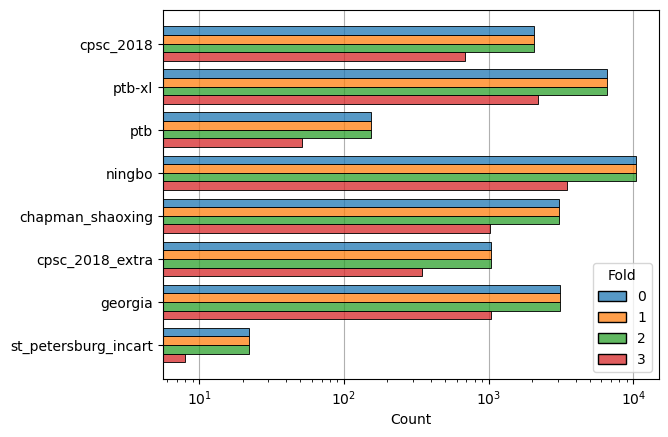

In [12]:
data_source = dataset.meta.original_filepath.apply(lambda x: Path(x).parents[1].name)
sns.histplot(y=data_source, hue=dataset.meta.Fold, multiple="dodge", palette="tab10", shrink=0.8, zorder=2)
plt.ylabel("")
plt.grid(axis="x")
plt.xscale("log")
plt.show()

## Correlation of labels

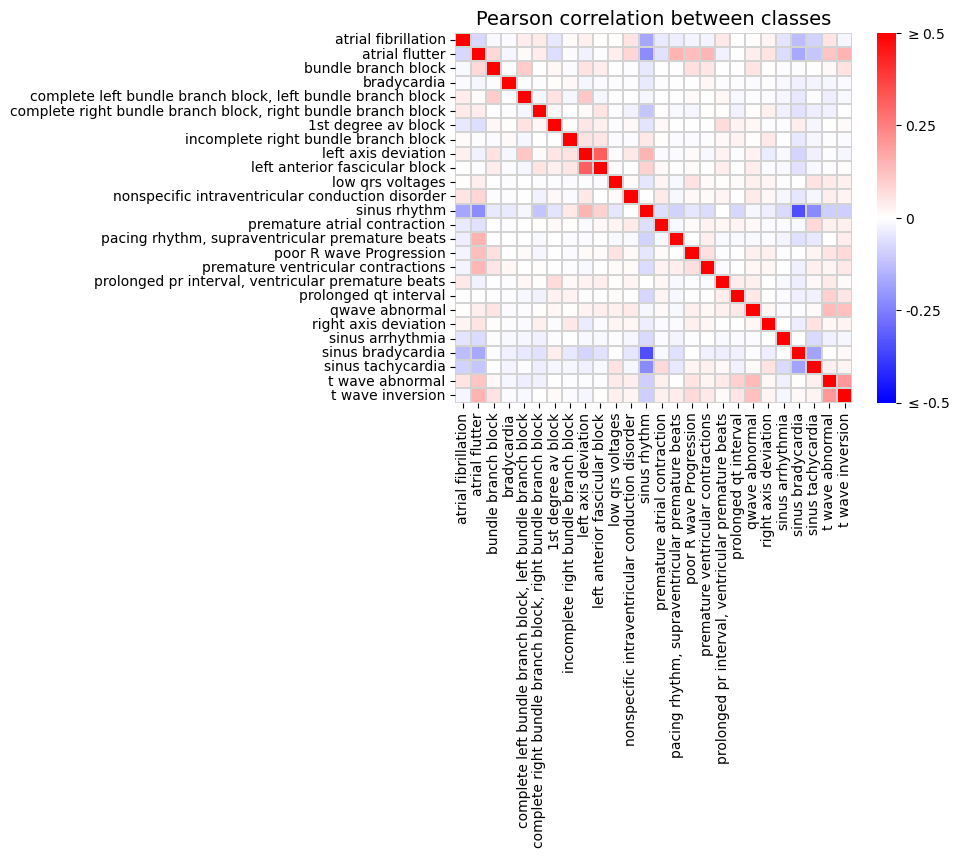

In [13]:
plt.title("Pearson correlation between classes", fontsize=14)
corr = pd.DataFrame(torch.corrcoef(y.T), columns=class_labels, index=class_labels)

heatmap = sns.heatmap(corr, cmap="bwr", vmin=-.5, vmax=.5, linewidths=0.01, linecolor="lightgray", yticklabels=class_labels)

colorbar = heatmap.collections[0].colorbar
colorbar.set_ticks([-0.5, -0.25, 0, 0.25, 0.5])  # Set major ticks
colorbar.set_ticklabels([r"$\leq$-0.5", "-0.25", "0", "0.25", r"$\geq$0.5"])  # Set tick labels
plt.show()

In [14]:
from sklearn.metrics import mutual_info_score

num_classes = y.shape[1]
pairwise_mi = np.zeros((num_classes, num_classes))
for i in range(num_classes):
    for j in range(num_classes):
        pairwise_mi[i, j] = mutual_info_score(y[:, i], y[:, j])

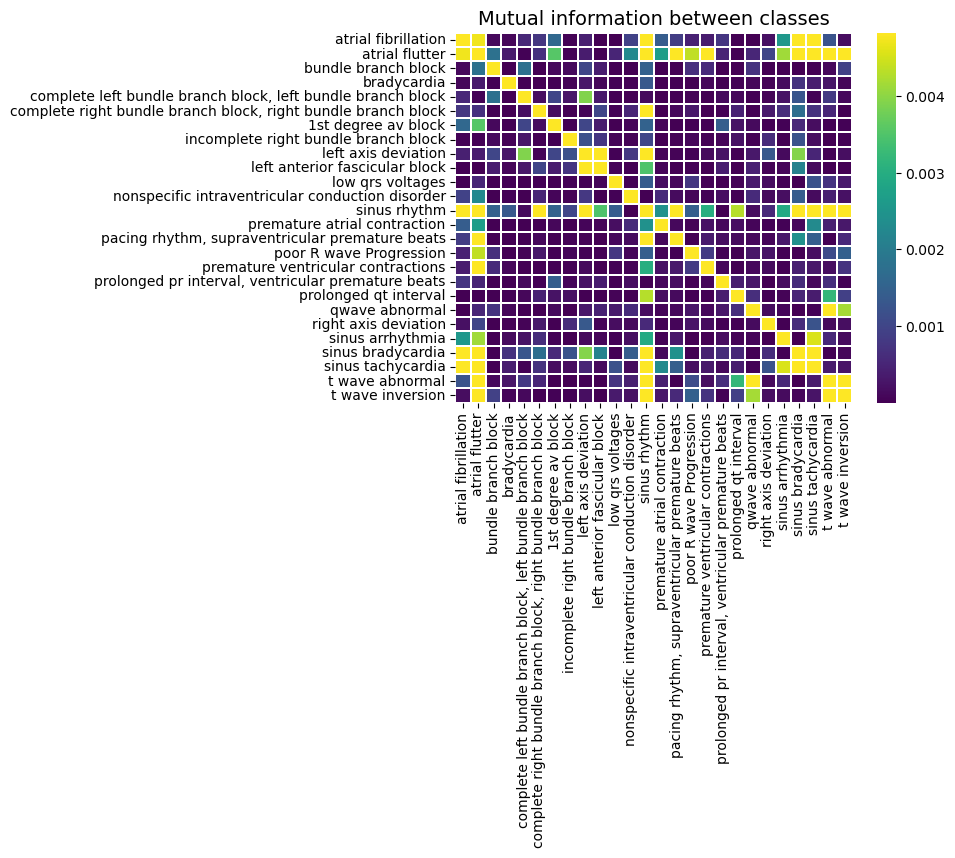

In [15]:
plt.title("Mutual information between classes", fontsize=14)
corr = pd.DataFrame(pairwise_mi, columns=class_labels, index=class_labels)
sns.heatmap(corr, cmap="viridis", linewidths=0.01, linecolor="white", yticklabels=class_labels,
            vmax=np.percentile(pairwise_mi, 90),
            vmin=np.percentile(pairwise_mi, 10))
plt.show()

## Effect of resampling on ECG length

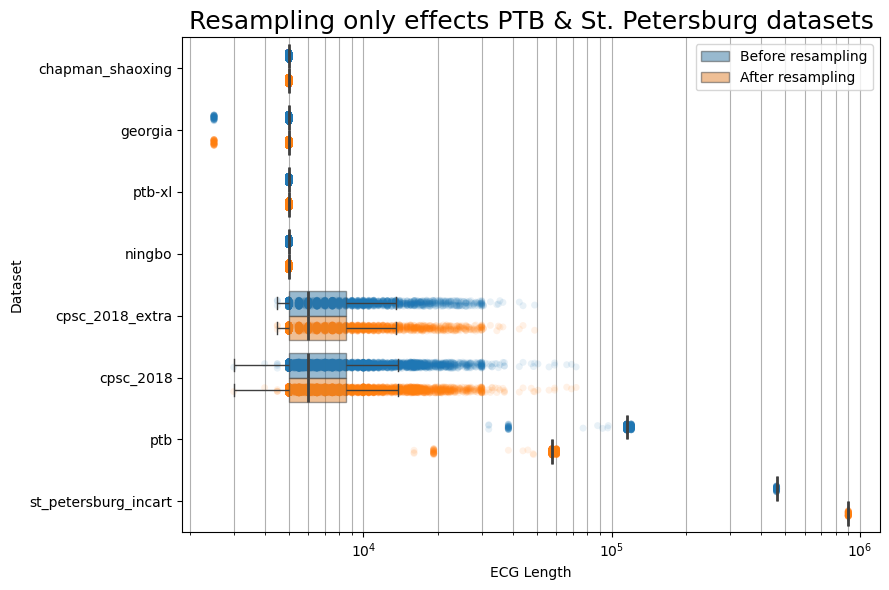

In [16]:
dataset_df = dataset.meta.copy()
dataset_df["dataset"] = dataset_df.original_filepath.apply(lambda x: Path(x).parents[1].name)

# Combine the lengths into a single DataFrame
dataset_df["length_type"] = "Before resampling"
dataset_df["length_value"] = dataset_df["length"]

resampled_df = dataset_df.copy()
resampled_df["length_type"] = "After resampling"
resampled_df["length_value"] = resampled_df["new_length"]

combined_df = pd.concat([dataset_df, resampled_df])

# Group by to get medians for ordering
medians = combined_df.groupby(["dataset", "length_type"])["length_value"].median()
order = (
    combined_df.groupby("dataset")["length_value"]
    .median()
    .sort_values()
    .index
)

# Plot
plt.figure(figsize=(9, 6))
sns.boxplot(
    data=combined_df,
    y="dataset",
    x="length_value",
    hue="length_type",
    palette="tab10",
    linewidth=1,
    medianprops=dict(linewidth=2),
    order=order,
    # fill=False,
    boxprops=dict(alpha=0.5),
    fliersize=0,
    zorder=3
)
sns.stripplot(
    data=combined_df,
    y="dataset",
    x="length_value",
    hue="length_type",
    dodge=True,
    alpha=0.1,
    palette="tab10",
    linewidth=0,
    order=order,
    legend=False,
    zorder=2
)

plt.xscale("log")
plt.xlabel("ECG Length")
plt.ylabel("Dataset")
plt.legend(title="")
plt.title("Resampling only effects PTB & St. Petersburg datasets", fontsize=18)
plt.grid(axis="x", which="both", zorder=0)
plt.tight_layout()
plt.show()

## Cross Validation

In [27]:
for fold in range(N_FOLDS - 1):
    data_module = PhysionetDM(ROOT / "metadata_v4.csv", fold=fold, batch_size=32, train_transform=BasicECGAugmentation())
    data_module.setup()

    train_loader = data_module.train_dataloader()
    valid_loader = data_module.val_dataloader()
    test_loader = data_module.test_dataloader()

    print(f"Fold {fold}:")
    print(f"\tValid fold = {data_module.valid_fold}, #Samples = {len(valid_loader)}")
    print(f"\tTrain fold = {data_module.train_folds}, #Samples = {len(train_loader)}")
    print(f"\tTest fold = {data_module.test_fold}, #Samples = {len(test_loader)}")
    print()

Fold 0:
	Valid fold = 0, #Samples = 828
	Train fold = [1, 2], #Samples = 1654
	Test fold = 3, #Samples = 276

Fold 1:
	Valid fold = 1, #Samples = 828
	Train fold = [0, 2], #Samples = 1654
	Test fold = 3, #Samples = 276

Fold 2:
	Valid fold = 2, #Samples = 828
	Train fold = [0, 1], #Samples = 1654
	Test fold = 3, #Samples = 276



## Data loading speed

In [14]:
from time import time
import multiprocessing
multiprocessing.cpu_count()

64

In [16]:
workers = [0, 8, 16, 32, 50]
times = []

for num_workers in workers[::-1]:

    data_module = PhysionetDM(ROOT / "metadata_v4.csv", fold=0, batch_size=64, num_workers=num_workers, val_transform=transform)
    data_module.setup()
    valid_loader = data_module.val_dataloader()

    # Warmup
    valid_loader = iter(valid_loader)
    _ = next(valid_loader)
    
    # Check data loading speed
    tic = time()
    for i, _ in enumerate(tqdm(valid_loader)):
        continue
    tac = time()

    times.append(tac - tic)

/home/jabareen/.conda/envs/ecg/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 50, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|█████████▉| 413/414 [01:44<00:00,  3.96it/s]


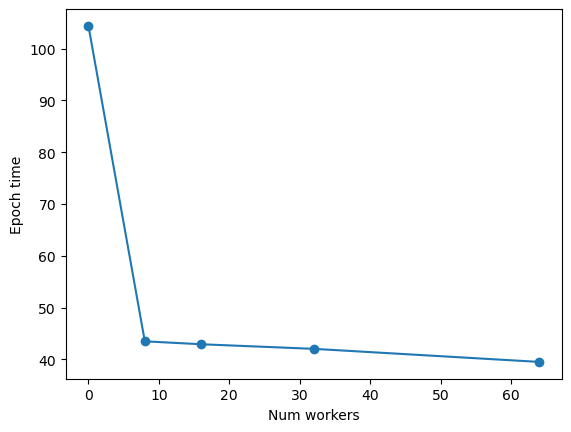

In [19]:
plt.plot(workers, times[::-1])
plt.scatter(workers, times[::-1])
plt.xlabel("Num workers")
plt.ylabel("Epoch time")
plt.show()